本文展示了如何多贝叶斯层次模型来解决盖革计数器问题。本文例子来自Allen B. Downey的《Think Bayes》一书，内容作了增补和修改。

盖革计数器
>盖革计数器（Geiger counter）又叫盖革-米勒计数器（Geiger-Müller counter），是一种用于探测电离辐射的粒子探测器，通常用于探测α粒子和β粒子，也有些型号盖革计数器可以探测γ射线及X射线。

# 盖革计数器问题

**问题描述** 

一个放射源，以平均每秒$r$个粒子的速度发射粒子。盖格计数器以$f$的比率记录发射出来的粒子。一般放射源会以固定的概率衰变。如果$f$为$10\%$，计数器在1秒内记录了15个粒子，那么计数器每秒记录到的粒子数$n$的后验分布是什么？放射源发射料子速度$r$的分布是什么？

**问题分析**
+ 放射源以每秒$r$的速率发射粒子，每秒到达计数器的粒子$n$个。
   + 由于原子的衰变概率相同，那么$n$的分布是一个参数为$r$的**泊松分布**。
+ 到达记数器的$n$个粒子中，计数器以比率$f$记录粒子数，$k$为记录到的粒子数。
   + 假设计数器检测到每个粒子的概率是独立的，则$k$的分布为参数为$n$和$f$的**二项分布**。



泊松分布

> 泊松分布（Poisson distribution）适合于描述单位时间内随机事件发生的次数的概率分布。如某一服务设施在一定时间内受到的服务请求的次数，电话交换机接到呼叫的次数、汽车站台的候客人数、机器出现的故障数、自然灾害发生的次数、DNA序列的变异数、放射性原子核的衰变数、激光的光子数分布等等。若$X$服从参数为$\lambda$的泊松分布，记为$X\sim \pi (\lambda)$或$X\sim \pi(\lambda)$。泊松分布的概率质量函数为：$$P(X=k)=\frac{e^{-\lambda}\lambda^{k}}{k!} \tag{1}$$泊松分布的参数$λ$是单位时间（或单位面积）内随机事件的平均发生率。  
> <center><img src="./statics/11/800px-Poisson_pmf.svg.png" width="480" alt="二项分布" align=center></center>
> <center>横轴是发生次数$k$。该函数是离散函数，$k$的定义域为整数，连接线是只为了视觉效果。</center><center><font size=4>概率质量函数</font></center>

二项分布

>二项分布（Binomial distribution）是n个独立的是/非试验中成功的次数的离散概率分布，其中每次试验的成功概率为$p$。这样的单次成功/失败试验又称为伯努利试验。实际上，当$n=1$时，二项分布就是伯努利分布。二项分布是显著性差异的二项试验的基础。一般地，如果随机变量$X$服从参数为$n$和$p$的二项分布，我们记$X\sim b(n,p)$。n次试验中正好得到k次成功的概率二项分布概率质量函为：$$f(k:n,p)=P(X=k)=
\left( 
  \begin{matrix}
   n \\
   k \\
  \end{matrix}
\right)p^{k}(1-p)^{n-k} \tag{2}
$$其中，$k=0,1,2,3,…,n$。  
> <center><img src="./statics/11/1024px-Binomial_distribution_pmf.svg.png" width="480" alt="二项分布" align=center></center>
> <center><font size=4>概率质量函数</font></center>

概率中的**正向问题**与**逆向问题**  
**正向问题**，根据参数计算数据的分布。  
**逆向问题**，根据数据计算参数的分布。  
如果能够解决正向问题，则可以运用贝叶斯方法解决逆向问题。

# 简单模型

**问题：** 将模型问题简化：已知$r$值和$f$值，求$n$的分布。  
**分析：** 由前面的分析可知，$n$的分布为泊松分布$n \sim \pi(r)$，$n$的分布又是计数器检测到料子数$k$的分布的参数，这是典型的逆向问题，根据计数器监测到的数据计算$k$的参数$n$。如下图所示。

<center><img src="./statics/11/反向模型 2019-09-22 195511.png" width="480" alt="二项分布" align=center></center>  
<center><font size=4>模型示意图</font></center>

## 生成泊松分布

In [5]:
from tools import Pmf

tools模块中的**Suite类**提供贝叶斯方法的基本操作。Suite对象具有属性d和name。
+ d：类型为“键-值”对组成的dict，键为随机变量取值，值为对应随机变量的概率值。
+ name：类型为string，保存Suite对象的名称。  

Suite类的方法主要有：
+ 'AddConstant',

In [8]:
def MakePoissonPmf(lam, high, step=1):
    """生成泊松分布的近似概率质量函数。

    lam: 参数lambda，单位时间内事件发生的数量
    high: 随机变量取值的上限

    返回: 标准化的概率质量函数
    """
    pmf = Pmf()
    for k in range(0, high + 1, step):
        # 当泊松分布的参数lambda的值为lam时，计算事件出现k次的概率
        p = EvalPoissonPmf(k, lam)
        pmf.Set(k, p)
    pmf.Normalize()
    return pmf

In [18]:
from scipy.stats import poisson
def EvalPoissonPmf(k, lam):
    """计算泊松分布的概率质量。

    k: 事件的数量
    lam: 参数lambda，单位时间内事件发生的数量

    返回: 概率值，浮点数
    """
    x = poisson.pmf(k, lam)
    return x if x else 0

**函数 MakePoissonPmf 的实例**  

当lam=150, high=150时, 函数MakePoissonPmf生成的概率质量函数的图形为。

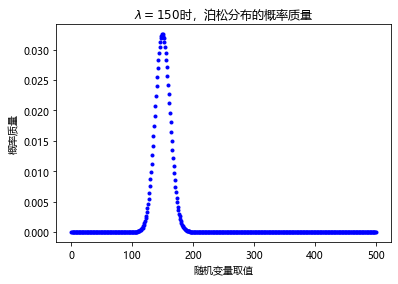

In [43]:
from matplotlib import pyplot as plt
# 生成lambda为150的泊松分布
possion_pmf = MakePoissonPmf(150, 500)
# 随机变量的取值列表和概率列表，作图用
x,y = zip(*possion_pmf.Items())

# 作图
plt.plot(x,y,".b")
plt.title('$\lambda=150$时，泊松分布的概率质量')
plt.xlabel('随机变量取值')
plt.ylabel('概率质量')
plt.show()

## 类Detector

In [44]:
from tools import Suite

tools模块中的**Suite类**继承自Pmf类，主要处理一组Pmf对象。

In [45]:
class Detector(Suite):
    """表示放射源发射离子数量n的分布的假设。"""

    def __init__(self, r, f, high=500, step=5):
        """初始化Suite对象。

        r: 已知离子发射速率, r
        f: 记录的离子数的比例, f
        high: 离子的最大数量, n
        step: n的假设值之间的步长
        """
        pmf = MakePoissonPmf(r, high, step=step)
        Suite.__init__(self, pmf, name=r)
        self.r = r
        self.f = f

    def Likelihood(self, data, hypo):
        """Likelihood of the data given the hypothesis.

        data: number of particles counted
        hypo: number of particles hitting the counter, n
        """
        k = data
        n = hypo
        p = self.f

        return thinkbayes.EvalBinomialPmf(k, n, p)

    def SuiteLikelihood(self, data):
        """Adds up the total probability of the data under the suite.

        data: number of particles counted
        """
        total = 0
        for hypo, prob in self.Items():
            like = self.Likelihood(data, hypo)
            total += prob * like
        return total